In [57]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from wordcloud import WordCloud
import nltk
nltk.data.path.append(r"c:\Users\Work\Desktop\projects\project2\project2-movie-env\Lib\site-packages\nltk")
from nltk.corpus import stopwords



#Options

In [58]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Work\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Work\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [59]:
pd.set_option('display.max_columns', None)
pd.set_option("display.float_format", lambda x: f"{x :.2f}")
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
stop_words = set(stopwords.words('french'))
stop_words.update(',',';','!','?','.','(',')','$','#','+',':','...',' ','Unknown')



# Connect to the database and create df



In [60]:
con = duckdb.connect('movies.db')

In [61]:
movies = con.table('movies').df()
con.close()

In [62]:
movies.head()

,backdrop_path,id,imdb_id,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,vote_average,vote_count,genres,actors,actors_id,directors,directors_id,video_name,video_key,keywords,production_company
0,/qYHM1QaR86eQeKX8qi8kFtqFAGd.jpg,655363,tt9834506,Post Mortem,"Hongrie, 1919. Miraculeusement revenu du front...",20.86,/4X47HT16UXf96cn1pI2hq31tX31.jpg,2020-10-28,115,Released,Immortalisez vos plus grandes peurs.,Post Mortem,6.72,194,"[Horreur, Mystère, Thriller]","[Viktor Klem, Fruzsina Hais, Judit Schell]","[1739471, 2481242, 125682]",[Péter Bergendy],[930499],[POST MORTEM Bande Annonce VF (2022)],[pv4NBtvy4zw],[],[Szupermodern Stúdió]
1,/dhr0q4eiRr8ltqPig32TwhPRdaD.jpg,17,tt0411267,The Dark,En débarquant dans cette contrée isolée du pay...,25.16,/ebzumprgCpfFUZOTJNZ407FA9IH.jpg,2005-09-28,87,Released,,The Dark,5.80,256,"[Horreur, Thriller, Mystère]","[Maria Bello, Sean Bean, Abigail Stone]","[49, 48, 55]",[John Fawcett],[43],[],[],"[sea, wales, child abuse, shepherd, adolescenc...","[Constantin Film, Impact Pictures, Isle of Man..."
2,/bQ8fRUaitJvi54O2lUT6Ta7FVHK.jpg,25,tt0418763,Jarhead,"Été 1990. Anthony Swofford, fils et petit‐fils...",73.51,/rpPa7dGWnuldRGyLtr4eT2n38jH.jpg,2005-11-04,123,Released,"La guerre, c’est l’enfer. L’attente, c’est pire.",Jarhead : La Fin de l'innocence,6.65,2750,"[Drame, Guerre]","[Jake Gyllenhaal, Jamie Foxx, Peter Sarsgaard]","[131, 134, 133]",[Sam Mendes],[39],[Jarhead: La fin de l'innocence (VF) - Bande A...,"[3wZjh-2PbIM, peoCGkXCCp4]","[california, gulf war, saudi arabia, petrol, m...","[Red Wagon Entertainment, Neal Street Producti..."
3,/pR12U3MPxq6aeHHd4sQOml72SSH.jpg,98339,tt1867093,The Samaritan,"Foley, un ancien arnaqueur, tente de changer d...",15.79,/5Lvo5OjSZmirakT8B7xxEnn1h1F.jpg,2012-03-02,90,Released,,Le Samaritain,5.40,197,[Thriller],"[Samuel L. Jackson, Luke Kirby, Ruth Negga]","[2231, 7002, 17018]",[David Weaver],[545229],[],[],"[prison, drug use, revenge, incest, grifter, p...","[H2O Motion Pictures, 2262730 Ontario, Middle ..."
4,/8ln5VUVk7gnNGIb2VNgw8nICDVt.jpg,35,tt0462538,The Simpsons Movie,Lorsque Homer pollue gravement le lac de Sprin...,74.65,/9Vz5sgIG10YNka14cv11dO5CfMF.jpg,2007-07-25,88,Released,La plus grande aventure familiale de tous les ...,"Les Simpson, le film",7.01,7714,"[Animation, Comédie, Familial]","[Dan Castellaneta, Julie Kavner, Nancy Cartwri...","[198, 199, 200]",[David Silverman],[197],"[LES SIMPSON - LE FILM (bande-annonce), Interv...","[8arbBxezySc, Ji32yfWuROQ]","[garbage, pollution, quarantine, environmental...","[Gracie Films, 20th Century Fox]"


# Start EDA

In [63]:
movies.describe()



,id,popularity,release_date,runtime,vote_average,vote_count
count,8640.00,8640.00,8640,8640.00,8640.00,8640.00
mean,314422.86,43.03,2014-12-31 20:52:50,105.16,6.53,1503.74
min,17.00,0.67,2004-05-13 00:00:00,0.00,5.00,150.00
25%,47762.25,21.14,2010-10-21 00:00:00,93.00,6.00,245.00
50%,291040.00,29.65,2015-07-22 12:00:00,102.00,6.50,478.00
75%,504582.75,44.72,2019-03-29 00:00:00,114.00,7.06,1351.25
max,1226841.00,1909.93,2024-04-19 00:00:00,247.00,9.10,35650.00
std,273342.11,59.99,NaN,18.21,0.72,2840.37


In [64]:
movies.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640 entries, 0 to 8639
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   backdrop_path       8635 non-null   object        
 1   id                  8640 non-null   int32         
 2   imdb_id             8639 non-null   object        
 3   original_title      8640 non-null   object        
 4   overview            8640 non-null   object        
 5   popularity          8640 non-null   float64       
 6   poster_path         8640 non-null   object        
 7   release_date        8640 non-null   datetime64[us]
 8   runtime             8640 non-null   int32         
 9   status              8640 non-null   object        
 10  tagline             8640 non-null   object        
 11  title               8640 non-null   object        
 12  vote_average        8640 non-null   float64       
 13  vote_count          8640 non-null   int32       

In [65]:
movies['vote_count'].describe()




count    8640.00
mean     1503.74
std      2840.37
min       150.00
25%       245.00
50%       478.00
75%      1351.25
max     35650.00
Name: vote_count, dtype: float64

In [66]:
movies['vote_average'].describe()



count   8640.00
mean       6.53
std        0.72
min        5.00
25%        6.00
50%        6.50
75%        7.06
max        9.10
Name: vote_average, dtype: float64

In [67]:
c = movies['vote_average'].mean()
c

6.531533564814814

In [68]:
#m= movies['vote_count'].quantile(0.5)
m = 150

In [69]:
def weighted_rating(df: pd.DataFrame,m: int=m, c: float=c)->float:
    v = df['vote_count']
    r = df['vote_average']
    return (v / (v+m)) * r + (m / (v+m)) * c



In [70]:
movies['imdb_score'] = movies.apply(weighted_rating, axis=1)

movies_sort_score = movies.sort_values(by='imdb_score', ascending=False)
movies_sort_score[['title','imdb_score','popularity','vote_count','vote_average']].head(10)




,title,imdb_score,popularity,vote_count,vote_average
46,The Dark Knight : Le Chevalier noir,8.51,131.51,31868,8.52
1256,Parasite,8.49,109.01,17483,8.51
3421,Your Name.,8.47,91.26,10943,8.50
7303,Interstellar,8.42,377.75,34232,8.43
8071,Spider-Man : New Generation,8.38,147.16,14954,8.40
1309,Le Château ambulant,8.38,136.04,9414,8.41
7520,Inception,8.36,373.58,35650,8.37
4743,Whiplash,8.36,194.92,14579,8.38
3544,Spider-Man : Across the Spider-Verse,8.33,221.02,6214,8.37
5294,Silent Voice,8.31,72.45,3772,8.38


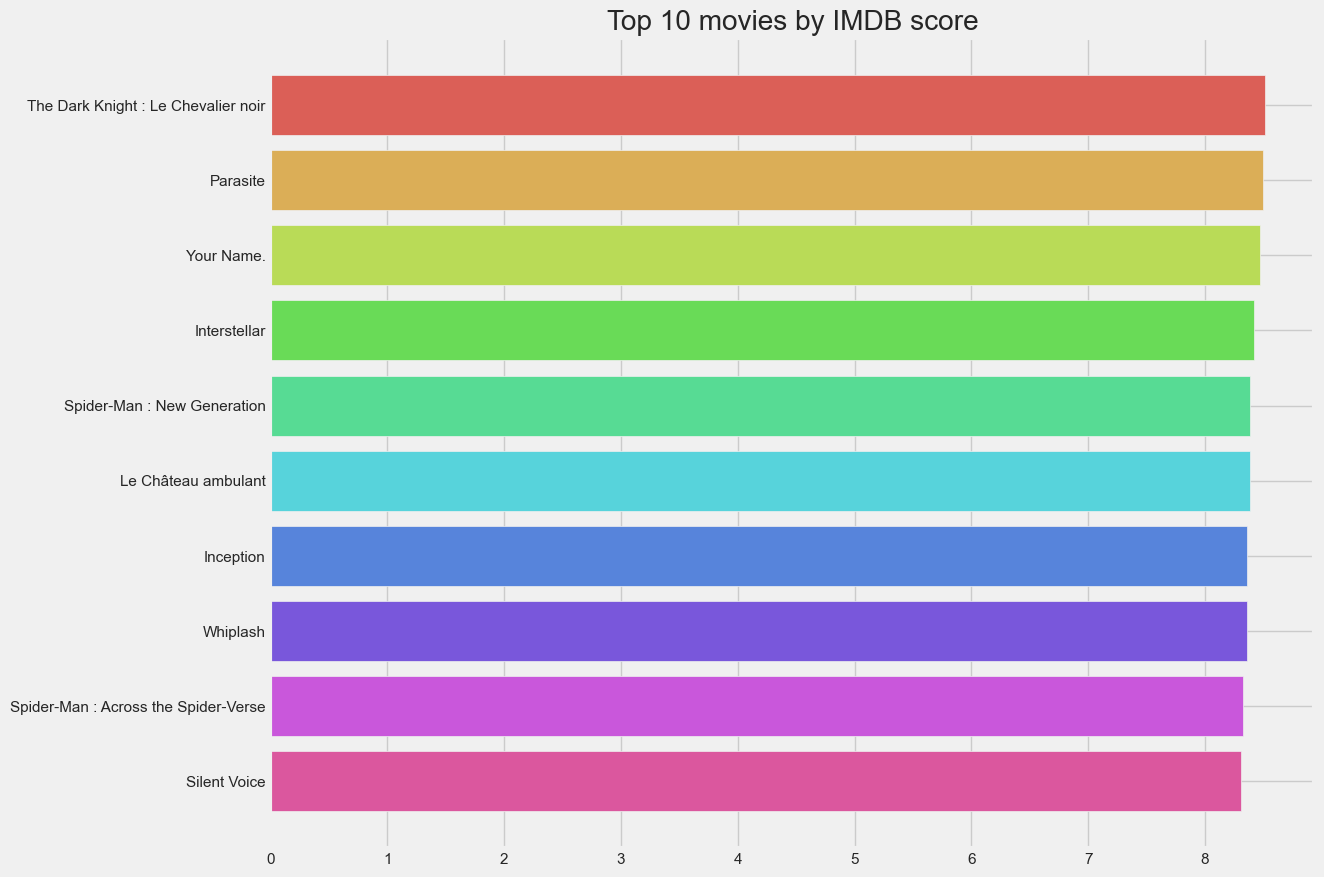

In [71]:
plt.subplots(figsize=(12,10))
plt.barh(movies_sort_score['title'].head(10),movies_sort_score['imdb_score'].head(10),color=sns.color_palette('hls',10))
plt.gca().invert_yaxis()
plt.title('Top 10 movies by IMDB score')
plt.show()



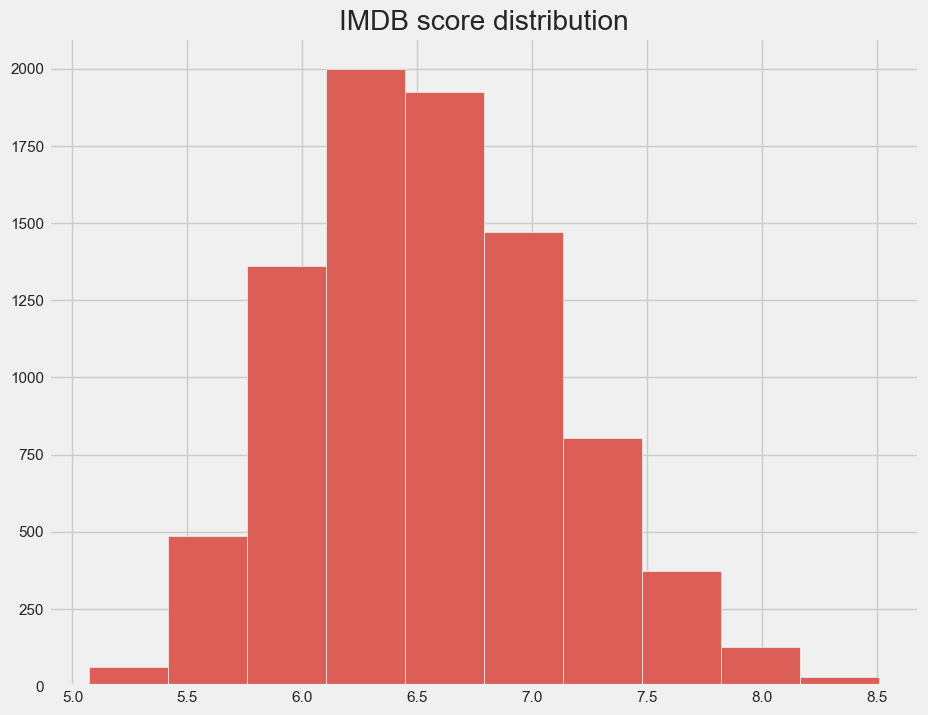

In [72]:
plt.subplots(figsize=(10,8))
plt.hist(movies['imdb_score'],bins=10,color=sns.color_palette('hls',1))
plt.title('IMDB score distribution')
plt.show()




In [73]:
movies.to_parquet('streamlit/data/movies.parquet')

# overview/tagline. trying out TF-IDF


In [74]:
#Define a TF-IDF Vectorizer Object. Remove all french stop words
tfidf = TfidfVectorizer(stop_words=list(stop_words), lowercase=True)



In [75]:
#add tagline to overview
movies['tagline'] = movies['tagline'].fillna('')
movies['description'] = movies['overview'] +' ' + movies['tagline']
#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(movies['description'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(8640, 35062)

In [76]:
combined_features2 = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
print(combined_features2.shape)



(8640, 35062)


In [77]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [78]:
#Construct a reverse map of index and movie titles
index = pd.Series(movies.index, index=movies['title']).drop_duplicates()

In [79]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(id, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    #idx = index[title]
    idx = movies.index[movies['id'] ==id][0]
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return (movies['title'].iloc[movie_indices],movies['id'].iloc[movie_indices])

In [80]:
movies2 = movies[['title','genres','actors','directors','keywords']]



# Genres columns

In [81]:
movies2['genres'] = movies2['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies2['genres'] = movies2['genres'].str.split(',')



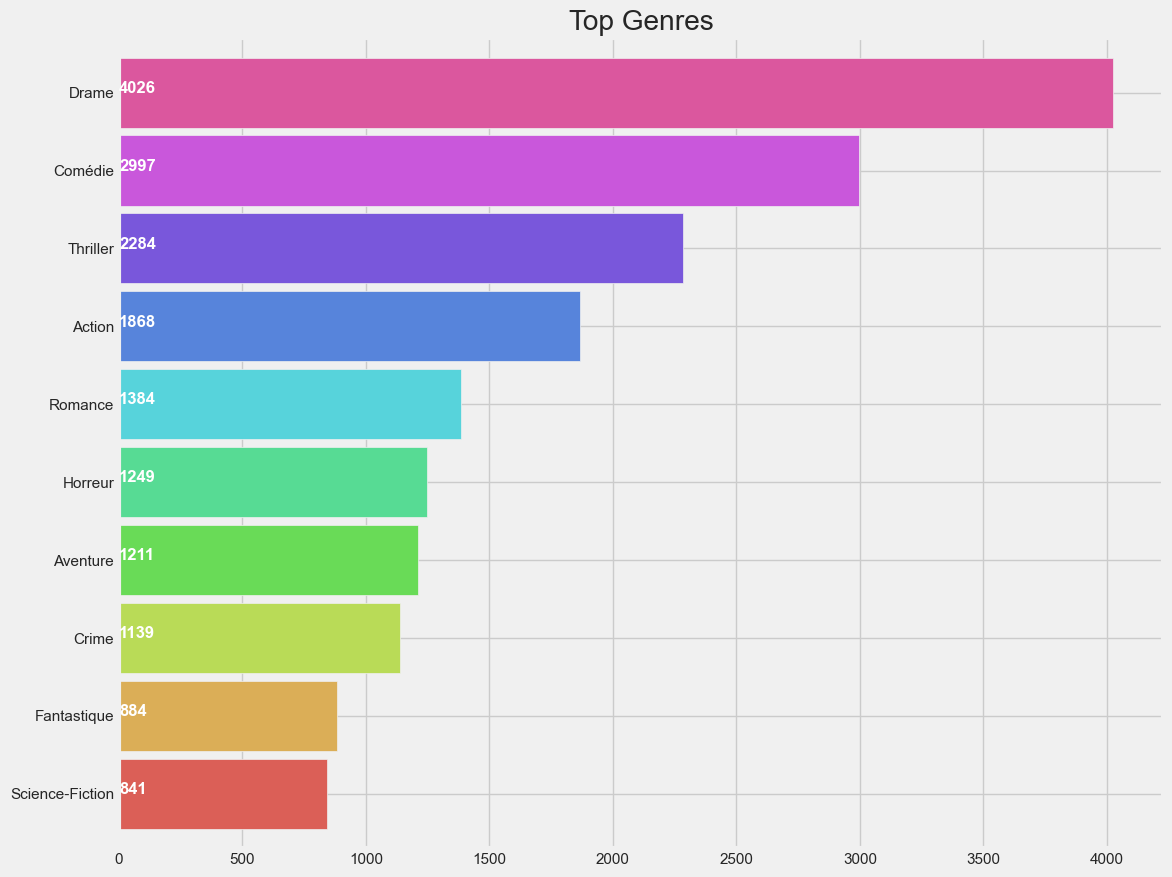

In [82]:
plt.subplots(figsize=(12,10))
list1 = []
for i in movies2['genres']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(0.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Genres')
plt.show()

# Actors columns

In [83]:
movies2['actors'] = movies2['actors'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
movies2['actors'] = movies2['actors'].str.split(',')



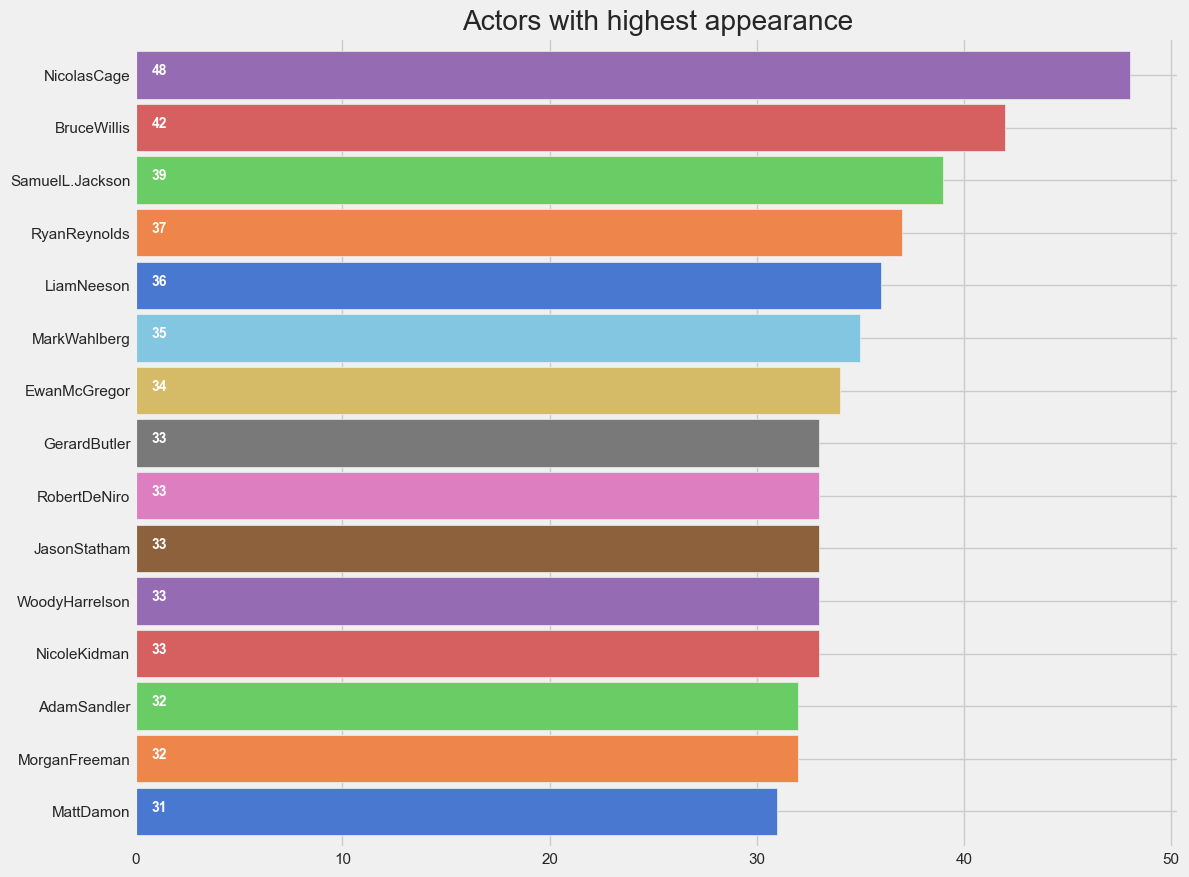

In [84]:
plt.subplots(figsize=(12,10))
list1=[]
for i in movies2['actors']:
    list1.extend(i)
ax=pd.Series(list1).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(pd.Series(list1).value_counts()[:15].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=10,color='white',weight='bold')
plt.title('Actors with highest appearance')
plt.show()

# directors column

In [85]:
movies2['directors'] = movies2['directors'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
movies2['directors'] = movies2['directors'].str.split(',')



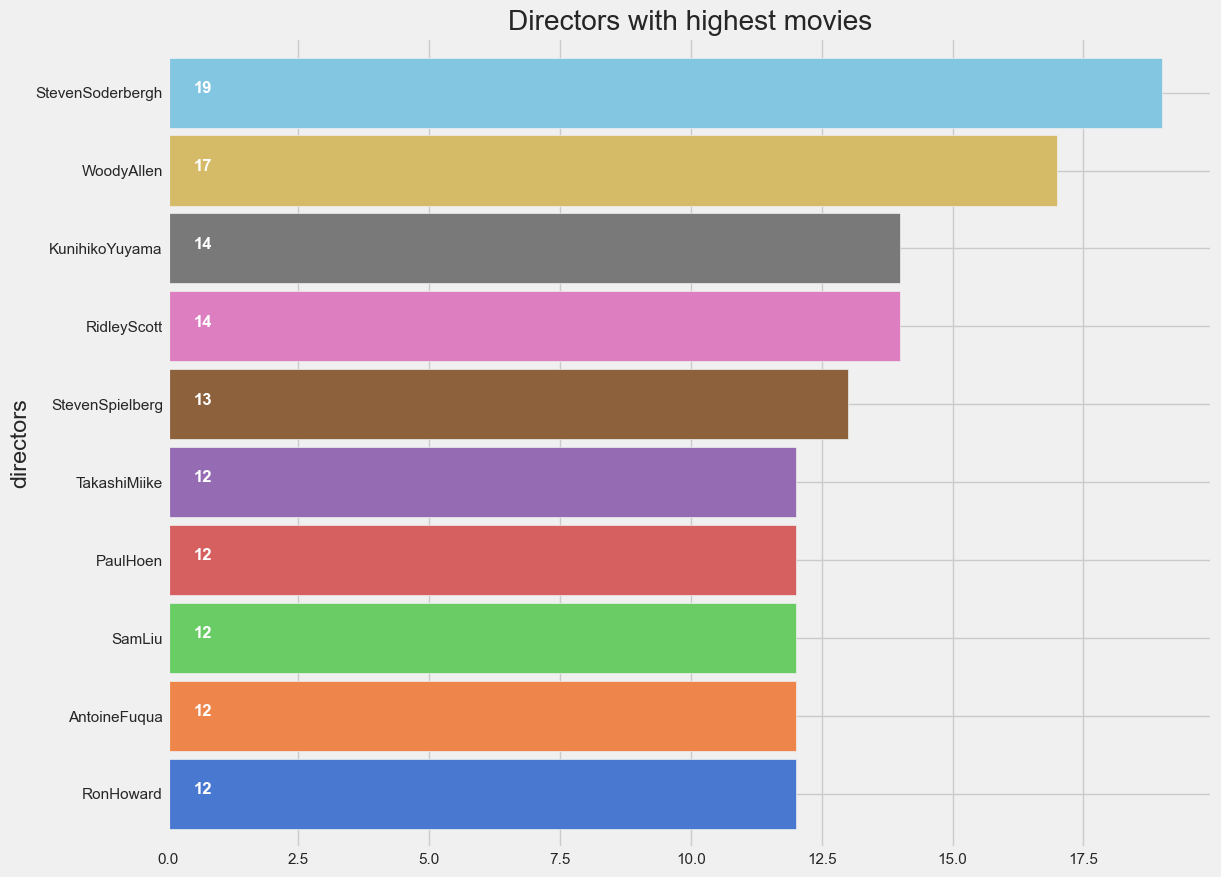

In [86]:
plt.subplots(figsize=(12,10))
filtered_movies = movies2[(movies2['directors'] != '') & (~movies2['directors'].apply(lambda x: 'Unknown' in x))]
ax = filtered_movies.explode('directors')['directors'].value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(filtered_movies.explode('directors')['directors'].value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.5, i, v,fontsize=12,color='white',weight='bold')
plt.title('Directors with highest movies')
plt.show()

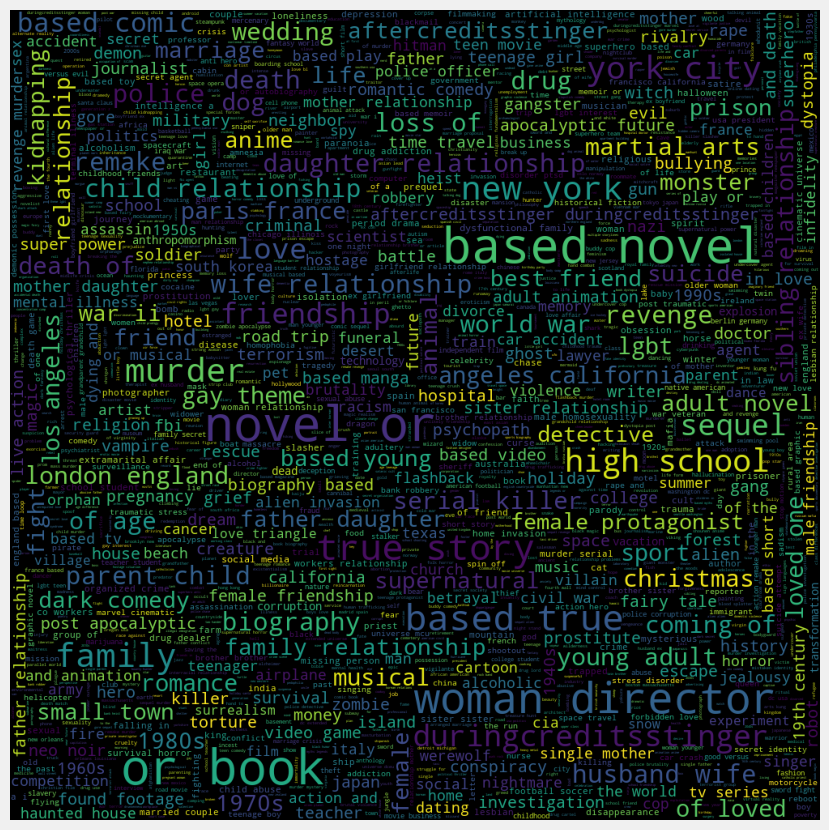

In [87]:
plt.subplots(figsize=(12,12))


words=movies2['keywords'].dropna().apply(nltk.word_tokenize)
word=[]
for i in words:
    word.extend(i)
word=pd.Series(word)
word=([i for i in word.str.lower() if i not in stop_words])
wc = WordCloud(background_color="black", max_words=2000, stopwords=stop_words, max_font_size= 60,width=1000,height=1000)
wc.generate(" ".join(word))
plt.imshow(wc)
plt.axis('off')
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

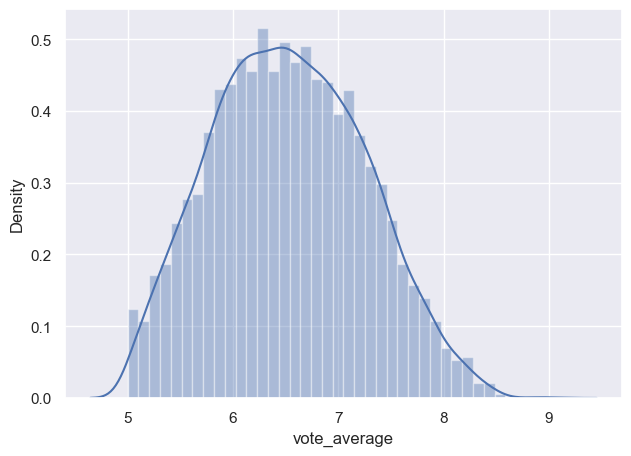

In [88]:
sns.set(color_codes=True)
sns.distplot(movies["vote_average"], );



In [89]:
liste_title = movies['title'].tolist()

In [90]:
random_title_choice = np.random.choice(liste_title)
#random_title_choice = 'Babysitting 2'
print(random_title_choice)

La Black Box


In [91]:
row = movies[movies['title'] == random_title_choice]
print(row.index[0])


7703


In [92]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''




In [93]:
features = ['actors', 'keywords', 'directors', 'genres', 'production_company']

for feature in features:
    movies[feature] = movies[feature].apply(clean_data)

In [94]:
def create_mix(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['actors']) + ' ' + x['directors'] + ' ' + ' '.join(x['genres']) + ' ' + ' '.join(x['production_company'])
movies['mixed'] = movies.apply(create_mix, axis=1)
#+ ' ' + ' '.join(x['description'])


In [95]:
movies['popularity_log'] = np.log1p(movies['popularity'])

In [96]:
columns_tfidf_to_encode = ['description']
columns_to_countvectorize = 'mixed'
columns_to_std = ['imdb_score','vote_average']

In [97]:
tfidf_transformers = [
    ('tfidf', TfidfVectorizer(stop_words=list(stop_words), lowercase=True), columns_tfidf_to_encode)
]
count_transformers = [
    ('count', CountVectorizer(stop_words=list(stop_words), lowercase=True), columns_to_countvectorize)
]
std_scale_transformers = [
    ('std_scale', StandardScaler(), columns_to_std)
]



In [98]:
all_transformers =count_transformers + std_scale_transformers

In [99]:
preprocessor = ColumnTransformer(all_transformers)
preprocessor

ColumnTransformer(transformers=[('count',
                                 CountVectorizer(stop_words=['et', ',', '!',
                                                             'aurai', 'on',
                                                             'mes', 'furent',
                                                             'aurons', 'fus',
                                                             'eue', 'est',
                                                             'ayant', 'm', 'en',
                                                             'par', '?', 'ton',
                                                             'eussiez', 'ayons',
                                                             'fussent', 'toi',
                                                             'étée', 'de',
                                                             'eut', 'qui',
                                                             'seras', 'la', '+',
                                                             'votre', 'étaient', ...]),
                                 'mixed'),
                                ('std_scale', StandardScaler(),
                                 ['imdb_score', 'vote_average'])])

In [100]:
# Example of manually applying a transformer to check output shape
transformer = TfidfVectorizer(stop_words=list(stop_words), lowercase=True)
sample_data = movies['description'].head()  # Assuming 'description' is a column
transformed_data = transformer.fit_transform(sample_data)
print(transformed_data.shape)  # Should be (n_samples, n_features)

(5, 227)


In [101]:


# Define the KNN model
knn_model = NearestNeighbors(n_neighbors=11, algorithm="auto")

# Combine preprocessing and KNN model using Pipeline
pipeline_with_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', knn_model)
])
pipeline_with_knn.fit(movies)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('count',
                                                  CountVectorizer(stop_words=['et',
                                                                              ',',
                                                                              '!',
                                                                              'aurai',
                                                                              'on',
                                                                              'mes',
                                                                              'furent',
                                                                              'aurons',
                                                                              'fus',
                                                                              'eue',
                                                                              'est',
                                                                              'ayant',
                                                                              'm',
                                                                              'en',
                                                                              'par',
                                                                              '?',
                                                                              'ton',
                                                                              'eussiez',
                                                                              'ayons',
                                                                              'fussent',
                                                                              'toi',
                                                                              'étée',
                                                                              'de',
                                                                              'eut',
                                                                              'qui',
                                                                              'seras',
                                                                              'la',
                                                                              '+',
                                                                              'votre',
                                                                              'étaient', ...]),
                                                  'mixed'),
                                                 ('std_scale', StandardScaler(),
                                                  ['imdb_score',
                                                   'vote_average'])])),
                ('knn', NearestNeighbors(n_neighbors=11))])

In [102]:
def find_nearest_neighbors(title : int, pipeline_with_knn : Pipeline, movies : pd.DataFrame) -> pd.DataFrame :
 
    df = movies[['mixed', 'imdb_score', 'vote_average','id']]
    # Filter the DataFrame to get the features of the specified product
    query_product_features = df[df['id'] == title].drop(columns=['id'])
    # Use the pipeline to preprocess the query product features
    query_product_features_processed = pipeline_with_knn.named_steps['preprocessor'].transform(query_product_features)

    # Use the KNN model to find the nearest neighbors for the query product
    nearest_neighbors_indices = pipeline_with_knn.named_steps['knn'].kneighbors(query_product_features_processed)[1][0]

    # Get the nearest neighbors' Product_IDs
    nearest_neighbors_product_ids = df.iloc[nearest_neighbors_indices]['id']

    # Create a DataFrame containing the nearest neighbors' information
    nearest_neighbors_df = df[df['id'].isin(nearest_neighbors_product_ids)]

    return nearest_neighbors_df[nearest_neighbors_df['id'] != title]

# Example usage:
query_product_id = 49026 # Specify the Product_ID of the query product
nearest_neighbors_df = find_nearest_neighbors(query_product_id, pipeline_with_knn, movies)

nearest_neighbors_df

,mixed,imdb_score,vote_average,id
36,"[ s e c r e t l o v e , w y o m i n g , u s a ...",7.77,7.80,142
93,"[ m a r t i a l a r t s , u n d e r c o v e r ...",7.70,7.71,272
302,"[ d y i n g a n d d e a t h , s u i c i d e , ...",8.18,8.20,1124
2993,"[ b a s e d o n n o v e l o r b o o k , t r e ...",7.76,7.80,10315
3757,"[ e m p i r e , f u t u r e , e p i c , a r m ...",7.77,7.79,438631
4354,"[ a r m y , b e a c h , f r a n c e , a l l i ...",7.44,7.45,374720
5704,"[ s c h o o l f r i e n d , d e p r e s s i o ...",7.77,7.79,84892
5977,[ h u s b a n d w i f e r e l a t i o n s h i ...,8.08,8.11,872585
6036,"[ a s s a s s i n , e s p i o n a g e , s p y ...",7.17,7.18,577922
7520,"[ r e s c u e , m i s s i o n , d r e a m , a ...",8.36,8.37,27205


In [103]:
count = CountVectorizer(stop_words=list(stop_words))
count_matrix = count.fit_transform(movies['mixed'])



In [104]:
scaler = StandardScaler()
#numerical_columns = ['imbd_score', 'popularity_log', 'vote_average']
numerical_columns = ['imdb_score', 'vote_average']
numerical_features = scaler.fit_transform(movies[numerical_columns])



In [105]:
# Concatenate text and numerical features
combined_features2 = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
combined_features = pd.DataFrame(count_matrix.toarray(), columns=count.get_feature_names_out())
combined_features[numerical_columns] = numerical_features

In [106]:
# Assuming numerical_columns is a list of column names for the numerical data
combined_features2 = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
combined_features = pd.DataFrame(count_matrix.toarray(), columns=count.get_feature_names_out())
numerical_features_df = pd.DataFrame(numerical_features, columns=numerical_columns)

In [107]:
print(combined_features2.shape)
print(combined_features.shape)
print(numerical_features_df.shape)

# If all shapes have the same number of rows, proceed to concatenate
if combined_features2.shape[0] == combined_features.shape[0] == numerical_features_df.shape[0]:
    final_features = pd.concat([combined_features2, combined_features, numerical_features_df], axis=1)
else:
    print("Error: DataFrames do not have the same number of rows")

(8640, 35062)
(8640, 3392)
(8640, 2)


In [108]:
cosine_sim2 = cosine_similarity(final_features, final_features)



In [109]:
movies = movies.reset_index()
indices = pd.Series(movies.index, index=movies['title'])

In [110]:
average_cosine_sim = (cosine_sim + cosine_sim2) / 2
get_recommendations(49026, average_cosine_sim)



(46          The Dark Knight : Le Chevalier noir
 93                                Batman Begins
 6255                                 The Batman
 4663    Batman : The Long Halloween 1ère Partie
 302                                 Le Prestige
 7303                               Interstellar
 7520                                  Inception
 5977                                Oppenheimer
 8066                       Lego Batman, le film
 1312               Zack Snyder's Justice League
 Name: title, dtype: object,
 46         155
 93         272
 6255    414906
 4663    736073
 302       1124
 7303    157336
 7520     27205
 5977    872585
 8066    324849
 1312    791373
 Name: id, dtype: int32)

In [111]:
get_recommendations(49026, cosine_sim2)



(46      The Dark Knight : Le Chevalier noir
 7303                           Interstellar
 7520                              Inception
 302                             Le Prestige
 5977                            Oppenheimer
 93                            Batman Begins
 4354                              Dunkerque
 3421                             Your Name.
 6297                       Dedicada A Mi Ex
 1309                    Le Château ambulant
 Name: title, dtype: object,
 46         155
 7303    157336
 7520     27205
 302       1124
 5977    872585
 93         272
 4354    374720
 3421    372058
 6297    644479
 1309      4935
 Name: id, dtype: int32)

In [112]:
get_recommendations(49026)



(4663            Batman : The Long Halloween 1ère Partie
 46                  The Dark Knight : Le Chevalier noir
 6255                                         The Batman
 8066                               Lego Batman, le film
 7399                                   Batman vs. Robin
 5966    Batman: La Malédiction Qui s'abattit sur Gotham
 4664            Batman : The Long Halloween 2ème Partie
 93                                        Batman Begins
 3206                    La Ligue des Justiciers : Échec
 5848                              Batman contre Dracula
 Name: title, dtype: object,
 4663     736073
 46          155
 6255     414906
 8066     324849
 7399     321528
 5966    1003579
 4664     736074
 93          272
 3206      76589
 5848      20077
 Name: id, dtype: int32)